# Movie Recommender system predict

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns

# Entity featurization and similarity computation
from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.feature_extraction.text import TfidfVectorizer

# Libraries used during sorting procedures.
import operator
import heapq 

# Imported for our sanity
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from surprise import Dataset, Reader, SVD, SVDpp, NMF, SlopeOne, CoClustering
from surprise.model_selection import cross_validate
import time
from sklearn.metrics import mean_squared_error
import re

In [2]:
# Importing data sets

genome_s = pd.read_csv('genome_scores.csv')
genome_t = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
TRAIN = pd.read_csv('train.csv')
TEST = pd.read_csv('test.csv')

## Replacing missing values

In [3]:
# imdb data
imdb_data['title_cast'] = imdb_data['title_cast'].fillna('')
imdb_data['director'] = imdb_data['director'].fillna('')
imdb_data['budget'] = imdb_data['budget'].fillna('')
imdb_data['runtime'] = imdb_data['runtime'].fillna('0')

# links
links['tmdbId'] = links['tmdbId'].fillna('0')

# tags
tags['tag'] = tags['tag'].fillna('')

## Basic EDA

Conduct some basic EDA in order to get a "feel" for the data and identify underlying trends. More EDA can be done, but the below is sufficient to get a general idea of a part of the data.

In [5]:
# create dataframe containing mivieId and genre
movie_genres = pd.DataFrame(movies[['movieId', 'genres']], columns = ['movieId', 'genres'])

# splitting the genres column on the | symbol and creating a list
movie_genres['genres'] = movie_genres['genres'].apply(lambda x: x.split('|'))

# manipulate dataframe such that each movie-genre is given in a seperate row
movie_genres = pd.DataFrame([(tup.movieId, d) for tup in movie_genres.itertuples() for d in tup.genres], columns = ['movieId', 'genres'])

movie_genres.head()

,movieId,genres
0,1,Adventure
1,1,Animation
2,1,Children
3,1,Comedy
4,1,Fantasy


<AxesSubplot:title={'center':'Most common genres\n'}, xlabel='count', ylabel='genres'>

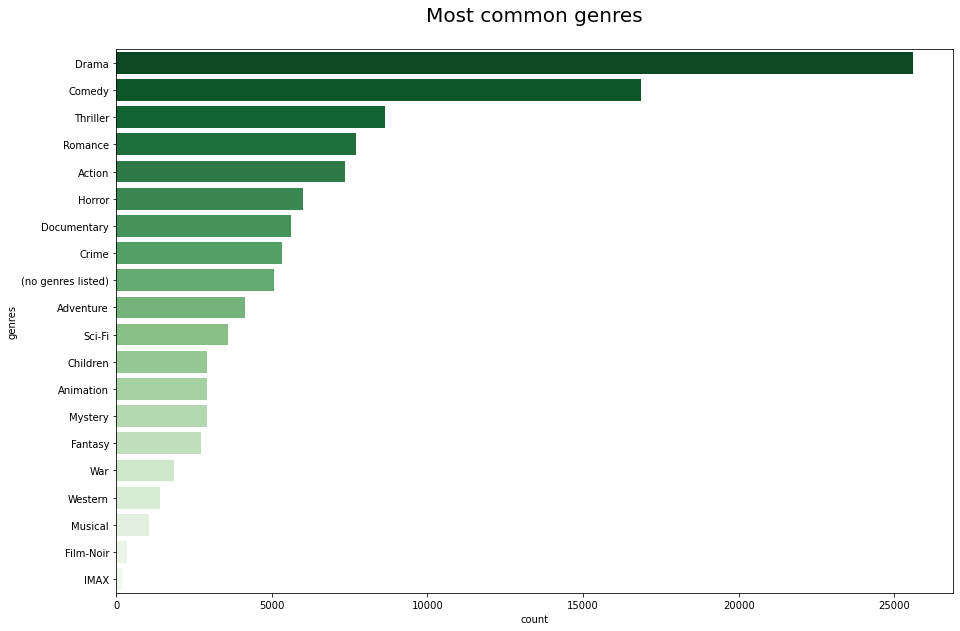

In [6]:
# plotting the different genres
plot = plt.figure(figsize = (15, 10))
plt.title('Most common genres\n', fontsize = 20)
sns.countplot(y = 'genres', data = movie_genres, order = movie_genres['genres'].value_counts(ascending = False).index, palette = 'Greens_r')

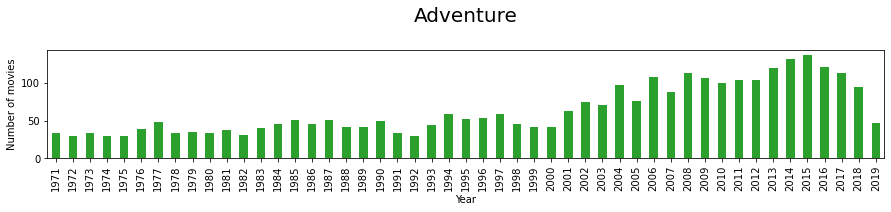

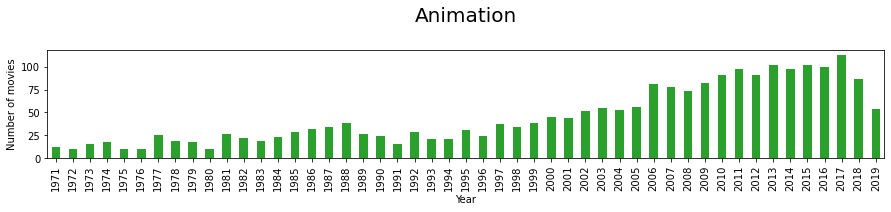

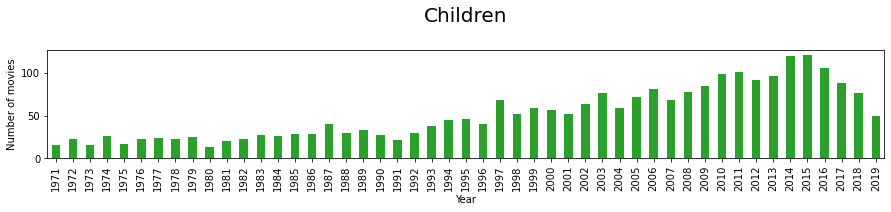

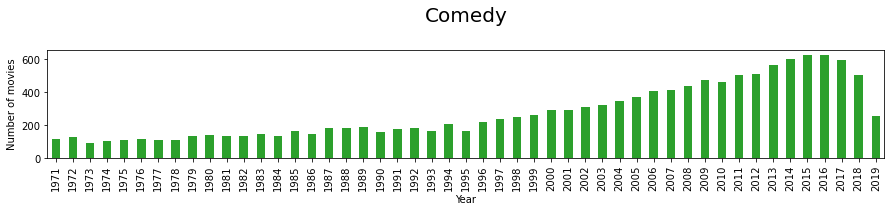

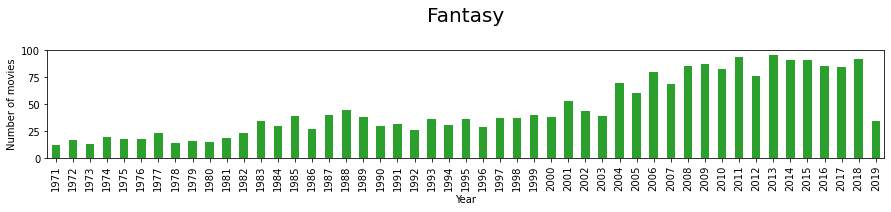

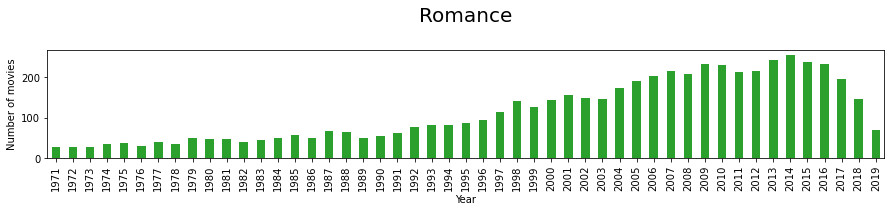

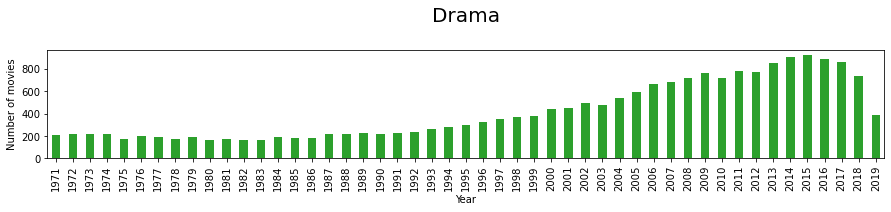

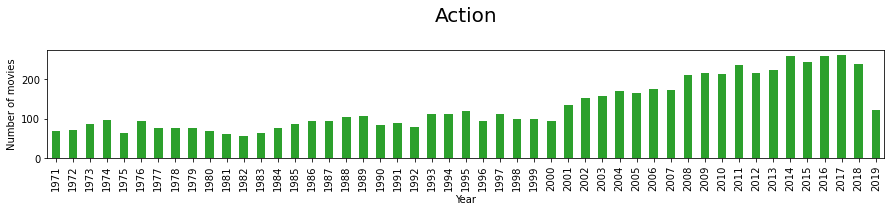

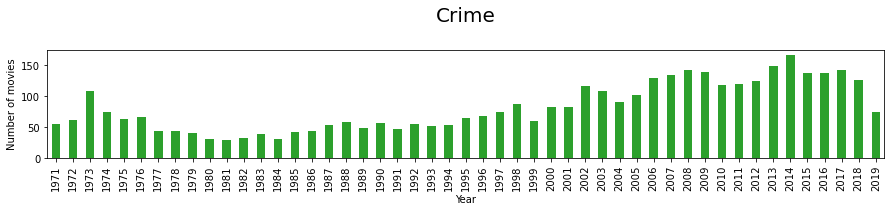

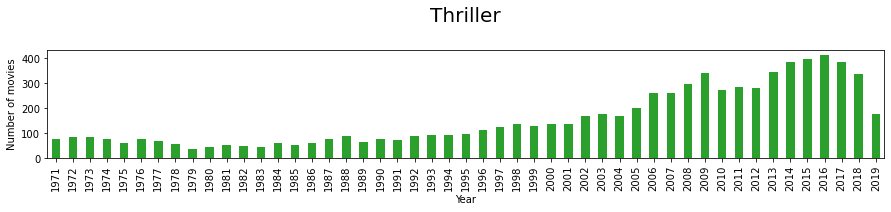

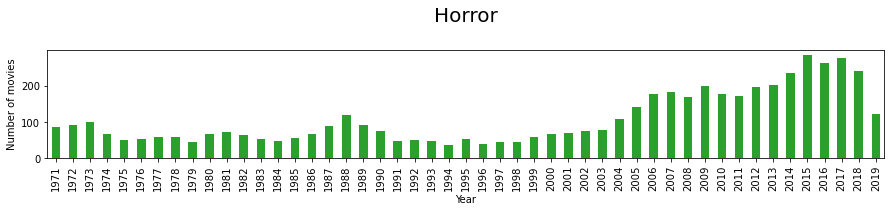

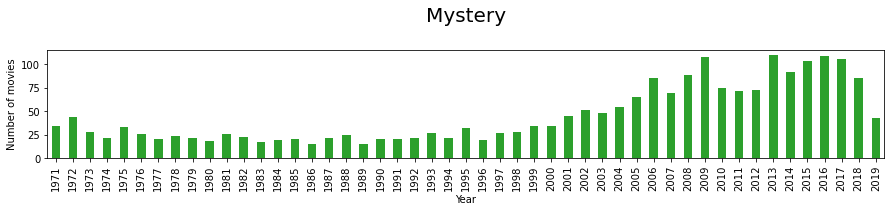

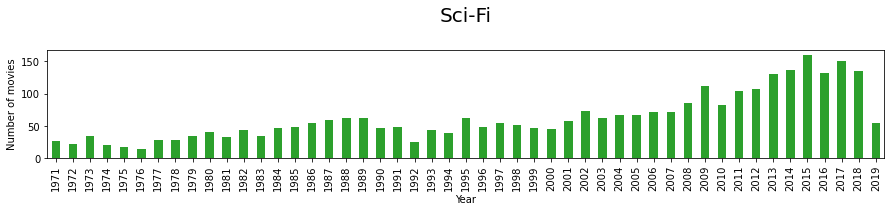

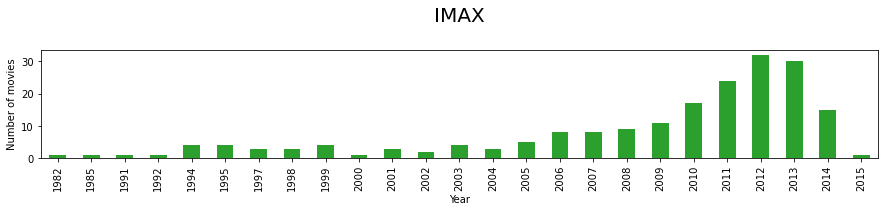

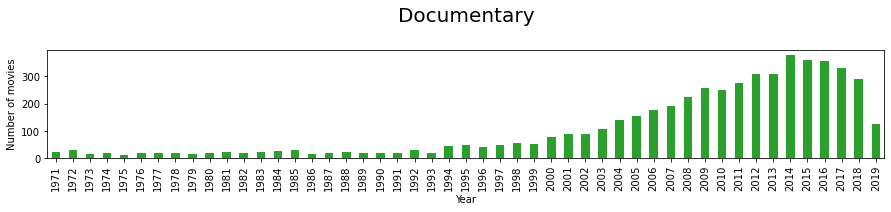

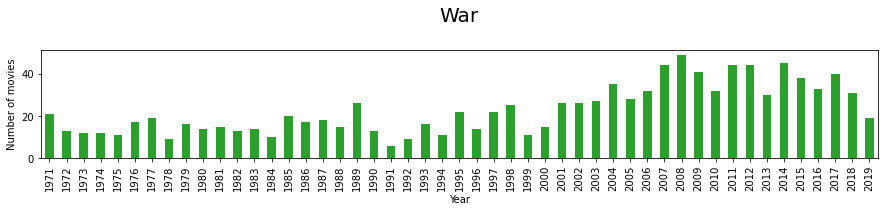

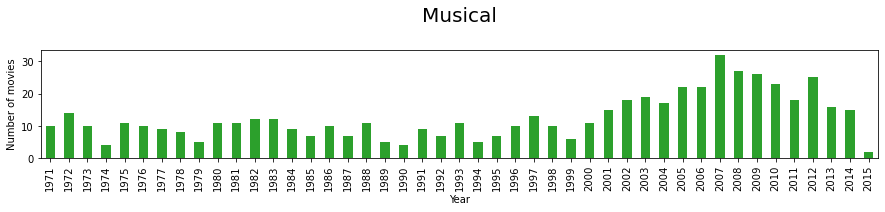

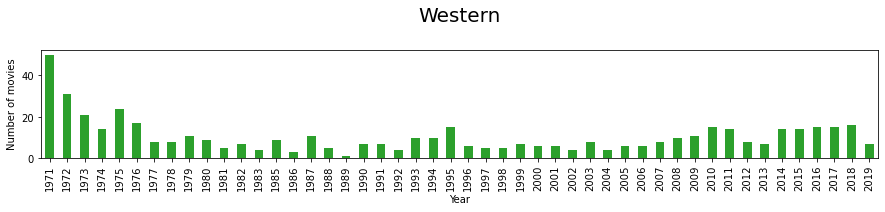

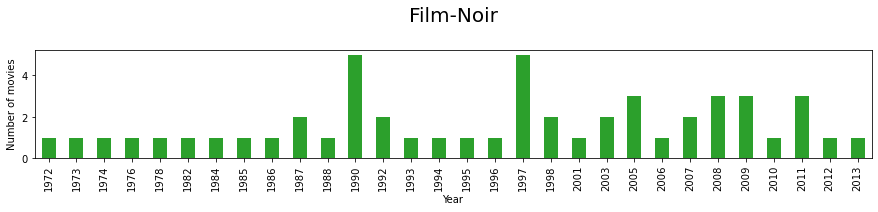

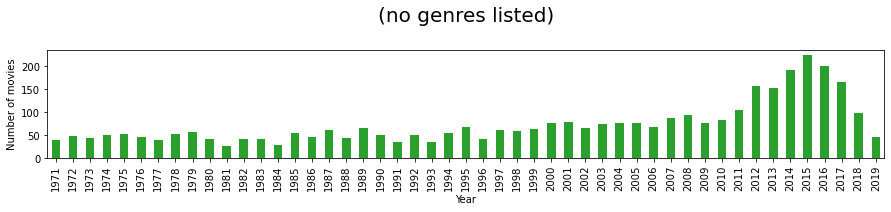

In [9]:
# Number of movies released per genre

# Adding release year column to the movies dataframe
years = movies['title'].apply(lambda x: re.findall(r'\((.[\d]+)\)', x))
movies['year'] = years.str[-1]

# create dataframe containing release year and genre for each movie
genres_year = pd.merge(movie_genres, movies[['movieId', 'year']], on = 'movieId', how = 'left')

# create list of unique genres
u_genres = list(movie_genres['genres'].unique())

# plotting number of movies released per genre per year
for i in u_genres:
    plot = plt.figure(figsize = (15, 2))
    plt.xlabel('Year')
    plt.ylabel('Number of movies')
    plt.title(f'{i}\n', fontsize = 20)
    genres_year[genres_year['genres'] == i][genres_year['year'].astype(float) > 1970]['year'].value_counts().sort_index().plot(kind = 'bar', color = 'tab:green')
    
plt.show()

In [10]:
# common tags

# create list of counts of each tag in the tag dataframe and order in descending manner
count_tags = tags['tag'].value_counts(ascending = False)

# create dataframe showing top ten tags and their corresponding counts
top_tags = list(zip(count_tags[:10].index, count_tags[:10]))
top_tags = pd.DataFrame(top_tags)
top_tags.columns = ['tag', 'count']
top_tags.style.background_gradient(cmap = 'Greens')

,tag,count
0,sci-fi,8330
1,atmospheric,6516
2,action,5907
3,comedy,5702
4,surreal,5326
5,based on a book,5079
6,twist ending,4820
7,funny,4738
8,visually appealing,4526
9,dystopia,4257


In [11]:
# average number of tags per movie

# list of number of tags per movie
list_frq = list(tags['movieId'].value_counts())

# determine most common number of tags per movie
highest_frq = max(set(list_frq), key = list_frq.count)

# ratio of movies containing the most common number of tags
ratio = round((list(count_tags).count(1) / len(count_tags)) * 100, 0)

# movie that has most amount of tags
max_frq = movies['title'][movies['movieId'] == tags['movieId'].value_counts(ascending = False).index[0]].values[0]

#findings
print(f'Most movies ({ratio}%) have {highest_frq} tag(s)\n')
print(f'{max_frq} has the max number of {max(list_frq)} tags')

Most movies (49.0%) have 1 tag(s)

Star Wars: Episode IV - A New Hope (1977) has the max number of 6180 tags


In [12]:
# significant tags

# find movies taht only have one significantly relevan tag and determine the count of the tags present
rel = genome_s[genome_s['relevance'] == genome_s['relevance'].max()]['tagId'].value_counts(ascending = False)

print(f'relevance score of the tags: {genome_s.relevance.max()}')

# create dataframe that contain top ten tags that are most relevant to their movies and their counts
rel_tags = list(zip(genome_t['tag'][list(rel[:10].index-1)], rel[:10]))
complete = pd.DataFrame(rel_tags)
complete.columns = ['tag', 'count']
complete.style.background_gradient(cmap = 'Greens')

relevance score of the tags: 1.0


,tag,count
0,007 (series),18
1,martial arts,10
2,aardman studios,8
3,view askew,7
4,time loop,5
5,goretastic,5
6,android(s)/cyborg(s),5
7,tom clancy,4
8,author:alan moore,4
9,vampire human love,4


In [13]:
# number of users in train dataset
print(len(TRAIN['userId'].unique()))

162541


In [14]:
# number of reviews in train dataset
print(len(TRAIN['movieId'].unique()))

48213


In [16]:
# total ratings per user and their average rating
user = TRAIN.groupby('userId').agg(num_ratings = ('movieId', 'size'), average_rating = ('rating', 'mean')).reset_index()

user.head()

,userId,num_ratings,average_rating
0,1,28,3.910714
1,2,72,3.416667
2,3,251,3.691235
3,4,89,3.308989
4,5,35,3.885714


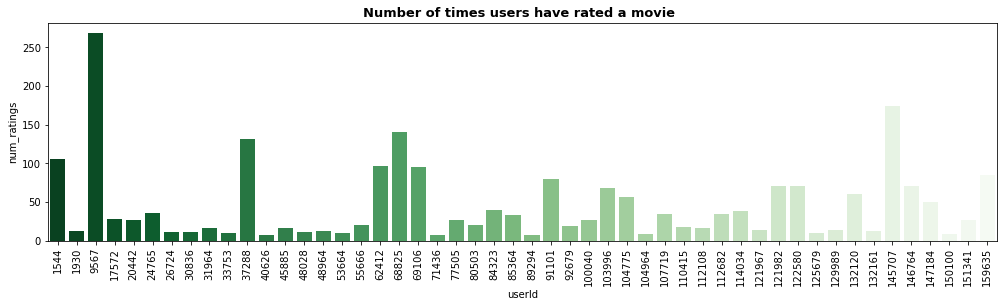

In [17]:
# visual representation of above data sampling 50 users
plot = plt.figure(figsize = (17, 4))
plt.figtext(.51, .85, 'Number of times users have rated a movie\n', fontsize = 13, ha = 'center', fontweight = 'bold')
sns.barplot(x = 'userId', y = 'num_ratings', data = user.sample(n = 50, random_state = 42).sort_values('num_ratings'), palette = 'Greens_r')
plt.xticks(rotation = 'vertical')

plt.show()

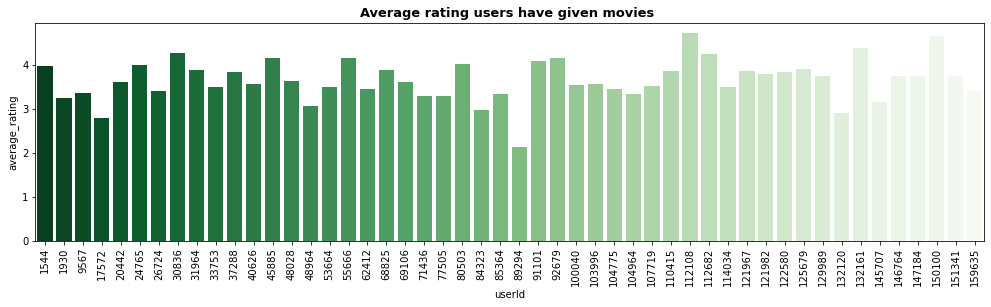

In [18]:
# average rating per users
plot = plt.figure(figsize = (17, 4))
plt.figtext(.51, .85, 'Average rating users have given movies\n', fontsize = 13, ha = 'center', fontweight = 'bold')
sns.barplot(x = 'userId', y = 'average_rating', data = user.sample(n = 50, random_state = 42).sort_values('num_ratings'), palette = 'Greens_r')
plt.xticks(rotation = 'vertical')

plt.show()

## Building the recommender system - Collaborative filtering - Model based

Fisrt fit a few models on a small fraction of the training data and evaluate which one performs the best according to the rmse metric.

In [4]:
# specify range of rating values
reader_eval = Reader(rating_scale = (0, 5))

# create train dataset
data_eval = Dataset.load_from_df(TRAIN.drop(['timestamp'], axis = 1).sample(frac = 0.01, random_state = 42), reader_eval)

In [5]:
# list to contain evaluation merics
evaluation = []

# list with model names and objects
model_list = [('SVD', SVD()), ('SVDpp', SVDpp()), ('NMF', NMF()), ('SlopeOne', SlopeOne()), ('CoClustering', CoClustering())]

# iterate over all algorithms
for model in model_list:
    # evaluate metric(s) by cross-validation
    results = cross_validate(model[1], data_eval, measures = ['RMSE'], cv = 3, verbose = False)
    
    # append algorithm name and evaluation results to list
    x = pd.DataFrame.from_dict(results).mean(axis = 0)
    x = x.append(pd.Series(model[0], index = ['model']))
    evaluation.append(x)

# output results as dataframe
pd.DataFrame(evaluation).set_index('model').sort_values('test_rmse')

,test_rmse,fit_time,test_time
model,,,
SVDpp,0.976086,0.808575,0.372680
SVD,0.979341,0.820743,0.187510
SlopeOne,1.144337,0.920684,0.170884
NMF,1.148001,2.653298,0.181845
CoClustering,1.150580,4.321330,0.153921


I will use the SVD model for the kaggle submission, as using the SVDpp model proved to hardware extensive to train as seen trying to execute it.

Now I proceed on to training the SVD model on its own and again evaluate its performance.

In [14]:
# training SVD model
# specify range of rating values
reader = Reader(rating_scale = (0, 5))

# extract testing data randomly
X_svd_test = TRAIN[['userId', 'movieId', 'rating']].sample(n = 5)
X_svd_train = TRAIN[['userId', 'movieId', 'rating']].drop(X_svd_test.index.values)

# create train dataset
data_svd = Dataset.load_from_df(X_svd_train, reader)
trainset_svd = data_svd.build_full_trainset()

In [30]:
# hyper-parameter tuning
# specify range of rating values
reader_sub = Reader(rating_scale = (0, 5))

# sample data randomly
X_svd_sub = TRAIN[['userId', 'movieId', 'rating']].sample(frac = 0.01, random_state = 42)

# create train dataset
data_svd = Dataset.load_from_df(X_svd_sub, reader_sub)

In [31]:
# train model

t0_svd = time.time()
SVD = SVD.fit(trainset_svd)
train_time_svdpp = time.time() - t0_svd

Let't take a look at the training time

In [32]:
print(train_time_svdpp)

122.64739537239075


Evaluation of model accuracy

In [33]:
# make predictions
predictions_svd = []
for i in range(len(X_svd_test)):
    a = X_svd_test.iloc[i][0]
    b = X_svd_test.iloc[i][1]
    predictions_svd.append(SVD.predict(a, b).est)

In [34]:
# looking at RMSE results
rmse = mean_squared_error(np.array(X_svd_test.rating).reshape(-1, 1), np.array(predictions_svd).reshape(-1, 1), 
                         squared = False)
print(rmse)

0.6175327528994837


## Creating Kaggle submission

In [42]:
train = TRAIN[['userId', 'movieId', 'rating']]
data = Dataset.load_from_df(train, reader)
trainset = data.build_full_trainset()

In [43]:
# train model

t0_svd = time.time()
SVD = SVD.fit(trainset)
train_time_svdpp = time.time() - t0_svd

In [44]:
print(train_time_svdpp)

129.5517168045044


In [45]:
# make predictions
predictions_svd = []
for i in range(len(TEST)):
    a = TEST.iloc[i][0]
    b = TEST.iloc[i][1]
    predictions_svd.append(SVD.predict(a, b).est)

In [50]:
daf = pd.DataFrame(predictions_svd, columns = ['rating'])
daf.head()

,rating
0,3.303858
1,4.277070
2,3.746825
3,4.286908
4,2.663812


In [57]:
ID = TEST
ID['Id'] = ID['userId'].map(str) + '_' + ID['movieId'].map(str)
ID.head()

,userId,movieId,Id
0,1,2011,1_2011
1,1,4144,1_4144
2,1,5767,1_5767
3,1,6711,1_6711
4,1,7318,1_7318


In [62]:
output = pd.DataFrame(ID['Id'])
output.head()

,Id
0,1_2011
1,1_4144
2,1_5767
3,1_6711
4,1_7318


In [63]:
submission = output.join(daf)
submission.to_csv('armand_de_wet_kaggle.csv', index = False)